In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import pickle
import numpy as np
from scipy.optimize import curve_fit

import crflux.models as pm

import  mceq_underground_helper_forsplines as helper

from helper_functions import sl_depth
import seaborn as sns

In [2]:
# for plotting

plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

colors = sns.color_palette("colorblind")

plot_dir = '/hetghome/khymon/Plots/cs-analysis/'

In [ ]:
def dNdN_mu(d, angle, p1, p2, p3):
    '''
        Get multiplicity intensity spectrum in cm-2 s-1 sr-1
        angle in deg (must match helper)
        p1, p2, p3: float 
    '''
    
    angle = 0.
    X = sl_depth(d,angle)
    season = "apr"
    threshold = 500.

    return 1e4*helper.mult_dist(X, angle,
                        pm.GlobalSplineFitBeta(),"yields_" + season, 
                        p1, p2,p3,
                        norm=False,threshold=threshold#))[0]
                    ) / helper.rates(X, angle, season, p1, p2, p3, threshold)

In [ ]:
def derivative(param,d, angle):
    ''' Calculate derviate dNdNmu/dmu for each spline parameter
        param: string
    '''
    if param =='p1':
        delta_dNdNmu = dNdN_mu(d, angle, 0.05, 0., 0.) - dNdN_mu(d, angle, -0.05, 0., 0.)
    elif param =='p2':
        delta_dNdNmu = dNdN_mu(d, angle, 0.0, 0.05, 0.) - dNdN_mu(d, angle, 0., -0.05, 0.)
    elif param =='p3':
        delta_dNdNmu = dNdN_mu(d, angle, 0.0, 0., 0.05) - dNdN_mu(d, angle, 0., 0., 0.05)

    return delta_dNdNmu/(2*0.05)

In [ ]:
# initialize helper - loads respective surace flux files

p1_values = [0.00, 0.05, -0.05, 0.00,  0.00, 0.00, 0.00]
p2_values = [0.00, 0.00,  0.00, 0.05, -0.05, 0.00, 0.00]
p3_values = [0.00, 0.00,  0.00, 0.00,  0.00, 0.05, -0.05]
season_values = ["jan", "apr", "jul"]  #  seasons



helper.initialize_flux_dicts(p1_values, p2_values, p3_values)
helper.some_function_that_uses_angles()
angles = helper.angles

Key: (0.0, 0.0, 0.0)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (0.05, 0.0, 0.0)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (-0.05, 0.0, 0.0)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (0.0, 0.05, 0.0)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (0.0, -0.05, 0.0)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (0.0, 0.0, 0.05)
Length of cos_thetas: 3
Shape of flux for season jan: (3, 121)
Shape of flux for season apr: (3, 121)
Shape of flux for season jul: (3, 121)
Key: (0.0, 0.0, -0.05

In [6]:
d = [1.5, 2.5]
angles = helper.angles
m = helper.n_mu_vec

In [ ]:
#calculate derivatesfor all angles and depths, array structure #shape=(depth,angle,multiplicities)

dNdNmu_da = np.ndarray(shape=(len(d), len(angles),len(m)))
dNdNmu_db = np.ndarray(shape=(len(d), len(angles),len(m)))
dNdNmu_dc = np.ndarray(shape=(len(d), len(angles),len(m)))

for i in range(len(d)):
    for j in range(len(angles)):
  
        dNdNmu_da[i][j] = derivative("p1",d[i],angles[j])
        dNdNmu_db[i][j] = derivative("p2",d[i],angles[j])
        dNdNmu_dc[i][j] = derivative("p3",d[i],angles[j])


In [ ]:
# get total derviative

a = 0.05
b = 0.05
c = 0.05

dNdNmu_def = np.ndarray(shape=(len(d), len(angles),len(m)))
for i in range(len(d)):
    for j in range(len(angles)):

        dNdNmu_def[i][j] = dNdN_mu(d[i], angles[j], 0., 0., 0.)
dNdNmu_mod = dNdNmu_def + dNdNmu_da * a  + dNdNmu_db * b + dNdNmu_dc * c

In [ ]:
# create function forone depth and angle that can be fitted
# returns dNdNmu/dmu in log10

a = 0.05
b = 0.05
c = 0.05

def f_mod(d, angle, a,b,c, multi):


    
    dNdNmu_da = derivative("p1",d,angle)
    dNdNmu_db = derivative("p2",d,angle)
    dNdNmu_dc = derivative("p3",d,angle)

    dNdNmu_def = dNdN_mu(d, angle, 0., 0., 0.)
    
    return np.log10(dNdNmu_def + dNdNmu_da * a  + dNdNmu_db * b + dNdNmu_dc * c)

In [ ]:
dNdNmu_mod_00 = f_mod(d=1.5,angle=0.,a=0.05,b=0.05,c=0.05,multi=np.log10(m)) # in log - index is the depth, 0 = 1.5km, 1 = 2.5km
dNdNmu_mod_10 = f_mod(d=2.5,angle=0.,a=0.05,b=0.05,c=0.05,multi=np.log10(m))



In [11]:
dNdNmu_mod_00

array([ -2.70226402,  -3.74334235,  -4.37161459,  -4.83558901,
        -5.20624428,  -5.51860695,  -5.78807931,  -6.02339671,
        -6.23033558,  -6.41724146,  -6.58609387,  -6.73869947,
        -6.87660888,  -7.00481819,  -7.1215824 ,  -7.23094353,
        -7.33262799,  -7.42697633,  -7.5156401 ,  -7.60169253,
        -7.6796679 ,  -7.75460183,  -7.82594983,  -7.89642422,
        -7.96047578,  -8.02277177,  -8.08262255,  -8.14022822,
        -8.2002599 ,  -8.25182241,  -8.30338072,  -8.35330139,
        -8.40168932,  -8.44863856,  -8.49386681,  -8.53836552,
        -8.58150739,  -8.62351384,  -8.66444578,  -8.70435937,
        -8.74330646,  -8.78257957,  -8.82226326,  -8.85692202,
        -8.89227053,  -8.92686416,  -8.9607353 ,  -8.99391255,
        -9.02642263,  -9.05829124,  -9.09059982,  -9.12344709,
        -9.15212623,  -9.18153054,  -9.21040424,  -9.23876563,
        -9.26663208,  -9.2940201 ,  -9.32094537,  -9.34742282,
        -9.37354568,  -9.39924777,  -9.42453491,  -9.44

<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\T'
<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\T'
<>:29: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1674242/4056584471.py:20: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel("dN/dN$_\mu$ (s cm$^2$ sr)$^{-1}$")
/tmp/ipykernel_1674242/4056584471.py:29: SyntaxWarning: invalid escape sequence '\T'
  ax1.text(0.1, -10, '$d=$' +str(d[i])+  'km, $\Theta=$' + str(np.round(angles[j],decimals=0)) + '$^{\circ}$', fontsize=12, color='grey')
/tmp/ipykernel_1674242/4056584471.py:29: SyntaxWarning: invalid escape sequence '\c'
  ax1.text(0.1, -10, '$d=$' +str(d[i])+  'km, $\Theta=$' + str(np.round(angles[j],decimals=0)) + '$^{\circ}$', fontsize=12, color='grey')


<Figure size 4135x3101.25 with 0 Axes>

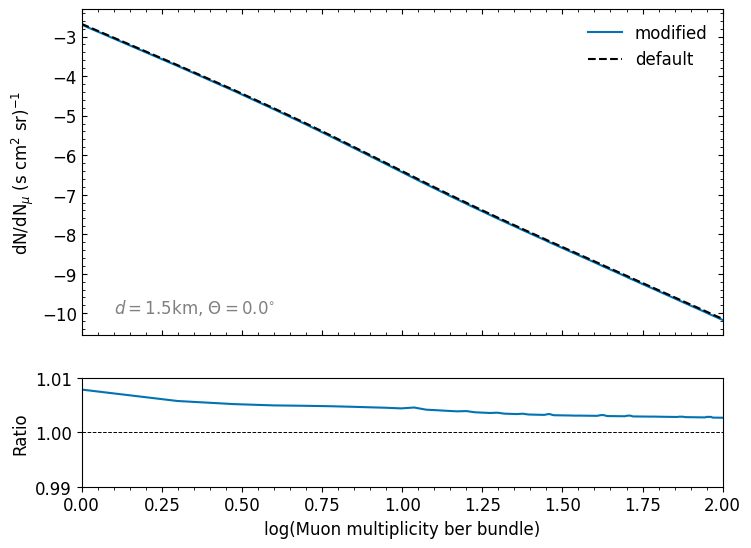

<Figure size 640x480 with 0 Axes>

<Figure size 4135x3101.25 with 0 Axes>

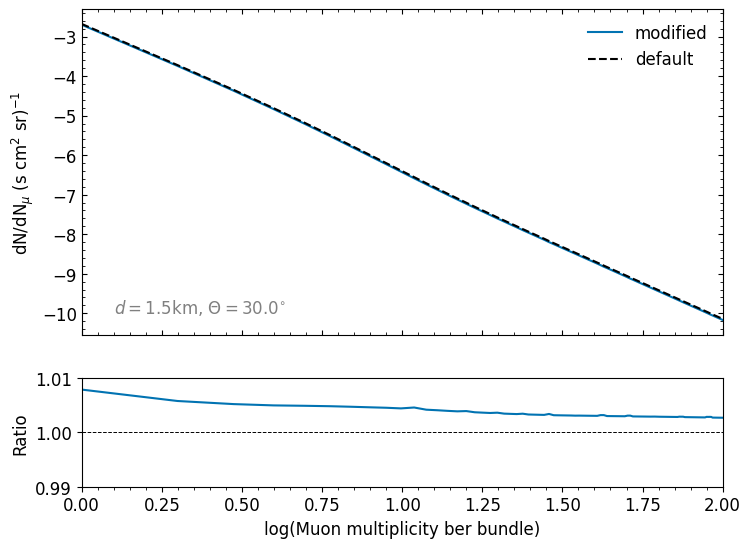

<Figure size 640x480 with 0 Axes>

<Figure size 4135x3101.25 with 0 Axes>

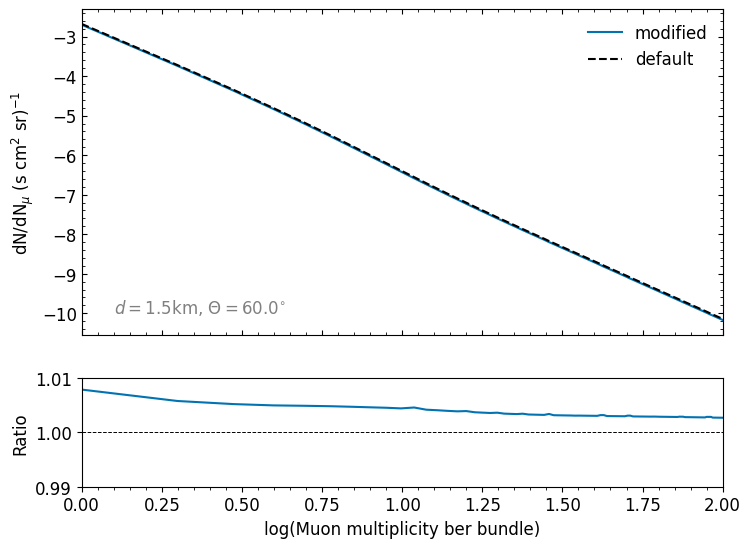

<Figure size 640x480 with 0 Axes>

<Figure size 4135x3101.25 with 0 Axes>

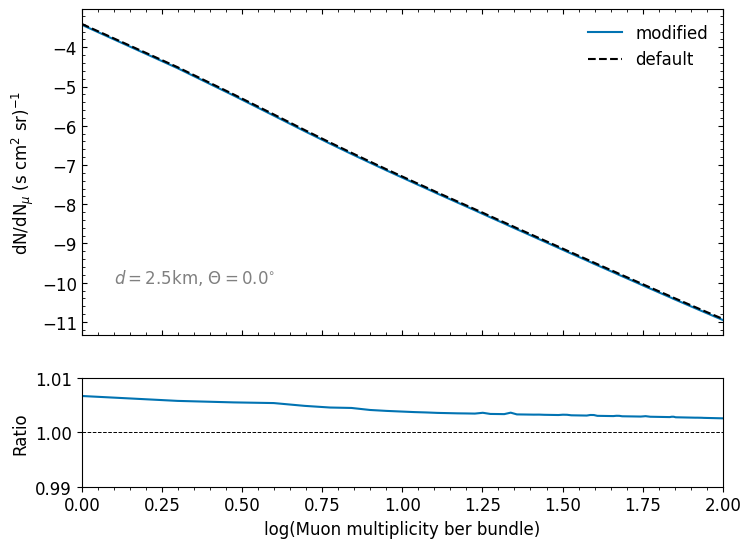

<Figure size 640x480 with 0 Axes>

<Figure size 4135x3101.25 with 0 Axes>

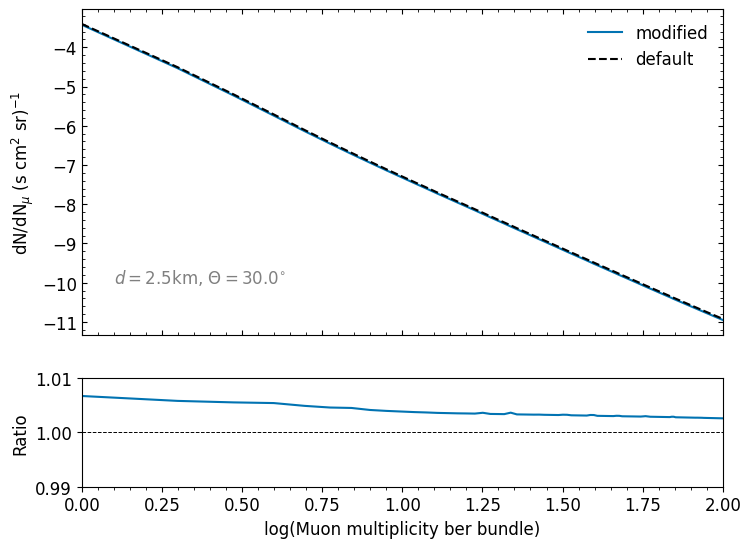

<Figure size 640x480 with 0 Axes>

<Figure size 4135x3101.25 with 0 Axes>

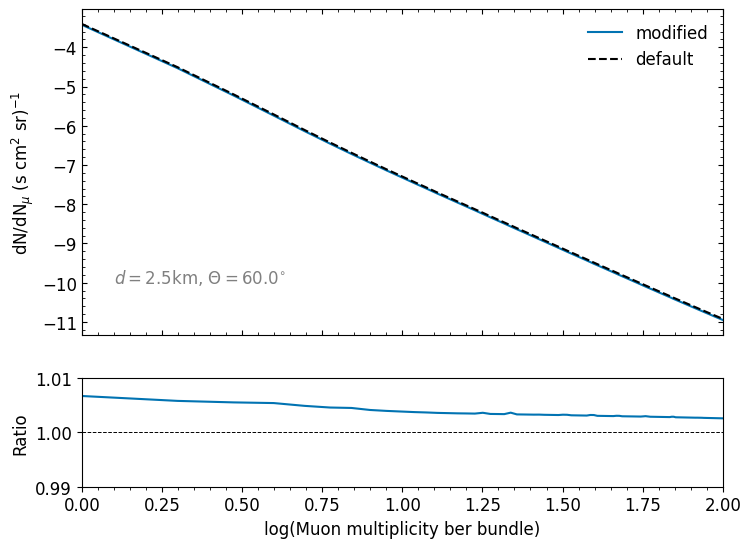

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot multiplicity spectrum for angle = 0., d=1.5km in log log

A4_width_inches = 8.27  # Width of A4 paper in inches
A4_height_inches = A4_width_inches * 0.75 # Height is one-third of width
figsize = (A4_width_inches, A4_height_inches)

for i in range(len(d)):
    for j in range(len(angles)):
        # Create subplots using GridSpec
        fig = plt.figure(figsize=figsize, dpi=500)
        fig.tight_layout(pad=0.4)

        # Create a gridspec with 2 rows and 1 column, where the second row will be narrow
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(A4_width_inches, A4_height_inches), sharex=True, height_ratios=[3,1 ])

        # Plot lines with labels (same as before)
        ax1.plot(np.log10(m), np.log10(dNdNmu_mod[i][j]), color=colors[0], label=r'modified')
        ax1.plot(np.log10(m), np.log10(dNdNmu_def[i][j]), color='black', label=r'default',ls='--')

        ax1.set_ylabel("dN/dN$_\mu$ (s cm$^2$ sr)$^{-1}$")
        plt.setp(ax1.get_xticklabels(), visible=False) 


        ax1.minorticks_on()
        ax1.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
        ax1.tick_params(axis='y', which='both', direction='in', left=True, right=True)

        ax1.legend( loc='upper right', frameon=False)
        ax1.text(0.1, -10, '$d=$' +str(d[i])+  'km, $\Theta=$' + str(np.round(angles[j],decimals=0)) + '$^{\circ}$', fontsize=12, color='grey')

        ax2.plot(np.log10(m), np.log10(dNdNmu_mod[i][j])/np.log10(dNdNmu_def[i][j]),  color=colors[0])
        ax2.plot([0.,2.],[1,1], lw=0.7, ls="--",color='black')

        ax2.set_xlabel('log(Muon multiplicity ber bundle)')
        ax2.set_ylabel('Ratio')
        ax2.set_ylim(0.99,1.01)
        ax2.set_xlim(0,2)


        # Save the figure
        plt.savefig(plot_dir+ "dNdNmu_def_vs_mod_0.05abc_angle" + str(np.round(angles[j],decimals=0)) + "_zenith" + str(d[i])+"deg.pdf", bbox_inches='tight')
        plt.show()
        plt.clf()

In [ ]:
#interpolate error from IceCube muon muplicity paper
# x-values (multiplicity given in absolute log10(N))

x_known = np.array([0.6,1.,1.5,2.])    
sigma_known = np.array([0.18, 0.14, 0.1, 0.08])  # observed uncertainties

# Define power-law model for sigma
def sigma_model(x, a, b):
    return a * x**b

# Fit model to known uncertainties
popt, _ = curve_fit(sigma_model, x_known, sigma_known)
a_fit, b_fit = popt

# Predict uncertainties for all multiplicities 
sigma_all = sigma_model(np.log10(m), a_fit, b_fit)


/tmp/ipykernel_1674242/1867686826.py:8: RuntimeWarning: divide by zero encountered in power
  return a * x**b


In [ ]:
sigma_all

array([       inf, 0.28739834, 0.21329882, 0.18347187, 0.16656558,
       0.15538067, 0.14729226, 0.14109437, 0.13614798, 0.13207971,
       0.12865522, 0.12571919, 0.12316412, 0.12091298, 0.11890893,
       0.11710901, 0.11548005, 0.113996  , 0.11263607, 0.11138343,
       0.11022431, 0.10914728, 0.10814282, 0.10720287, 0.1063206 ,
       0.10549014, 0.10470643, 0.10396511, 0.10326234, 0.10259477,
       0.10195945, 0.10135376, 0.10077538, 0.10022223, 0.09969246,
       0.09918439, 0.09869652, 0.09822748, 0.09777605, 0.0973411 ,
       0.09692161, 0.09651663, 0.09612532, 0.09574689, 0.0953806 ,
       0.0950258 , 0.09468186, 0.09434823, 0.09402435, 0.09370976,
       0.09340398, 0.09310659, 0.09281721, 0.09253545, 0.09226096,
       0.09199344, 0.09173256, 0.09147805, 0.09122964, 0.09098707,
       0.0907501 , 0.09051852, 0.0902921 , 0.09007066, 0.08985399,
       0.08964193, 0.08943429, 0.08923093, 0.08903168, 0.08883641,
       0.08864497, 0.08845723, 0.08827307, 0.08809238, 0.08791

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1674242/3503301775.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Absolute Error log($N_{\mu}$)')


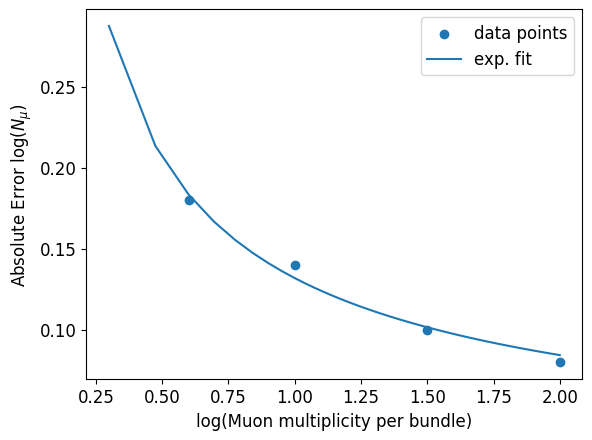

In [ ]:
# test plot for interpolation

plt.scatter(x_known,sigma_known,label='data points')
plt.plot(np.log10(m),sigma_all,label='exp. fit')
plt.xlabel('log(Muon multiplicity per bundle)')
plt.ylabel('Absolute Error log($N_{\mu}$)')
plt.legend()

In [31]:
# fit optimal a, b ,c
fit_func = lambda x, a, b, c: f_mod(1.5, 0., a, b, c, x)


sigma_test = 0.1 * dNdNmu_mod_00 #(assuma 10% error)

popt, pcov = curve_fit(fit_func, np.log10(m), dNdNmu_mod_10, p0=[0.0, 0.0, 0.0], sigma=sigma_test, absolute_sigma=True)


/tmp/ipykernel_1674242/2036266346.py:15: RuntimeWarning: invalid value encountered in log10
  return np.log10(dNdNmu_def + dNdNmu_da * a  + dNdNmu_db * b + dNdNmu_dc * c)
/tmp/ipykernel_1674242/4029595307.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit_func, np.log10(m), dNdNmu_mod_10, p0=[0.0, 0.0, 0.0], sigma=sigma_test, absolute_sigma=True)


In [32]:
popt


array([0.71779891, 1.30161042, 0.        ])

In [33]:
pcov

array([[inf, inf, inf],
       [inf, inf, inf],
       [inf, inf, inf]])

In [ ]:
# save files to folder
#with open("/hetghome/khymon/cs-files/dNdNmu_fit-pi-air.pkl", "wb") as f:
#    pickle.dump(popt, pcov), f))

In [ ]:
# test different fit methods

In [22]:
from scipy.odr import ODR,Model, RealData

# Define the ODR-compatible model
def odr_model(beta, x):
    a, b, c = beta
    return f_mod(1.5, 0., a, b, c, x)

data = RealData(np.log10(m), dNdNmu_mod_00, sx=sigma_all)

model = Model(odr_model)
odr = ODR(data, model, beta0=[0.02, 0.03, 0.01])
output = odr.run()

In [23]:
popt = output.beta
pcov = output.cov_beta

In [24]:
pcov

array([[8.80829259e-02, 3.08666667e+00, 0.00000000e+00],
       [3.08666667e+00, 1.65294089e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [25]:
popt

array([0.05, 0.05, 0.01])

In [26]:
param_errors = np.sqrt(np.diag(output.cov_beta))
param_errors

array([ 0.29678768, 12.85667488,  0.        ])